[*********************100%***********************]  1 of 1 completed


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

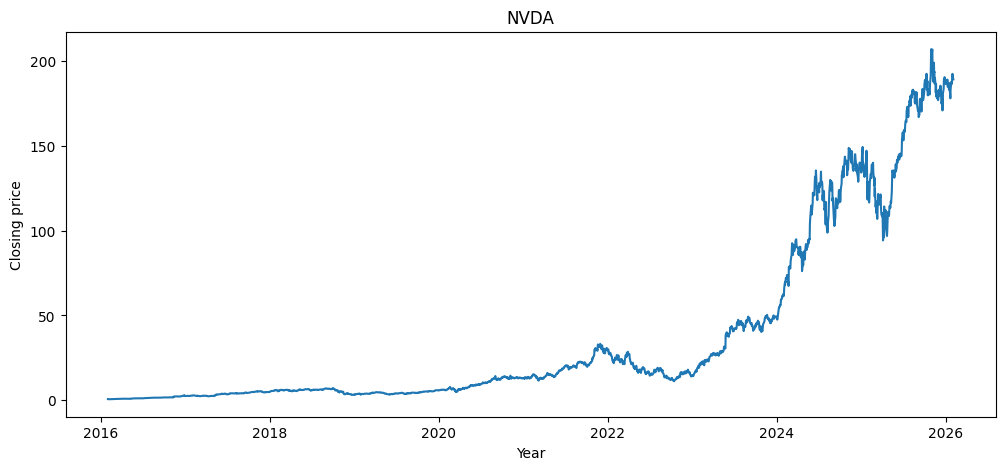

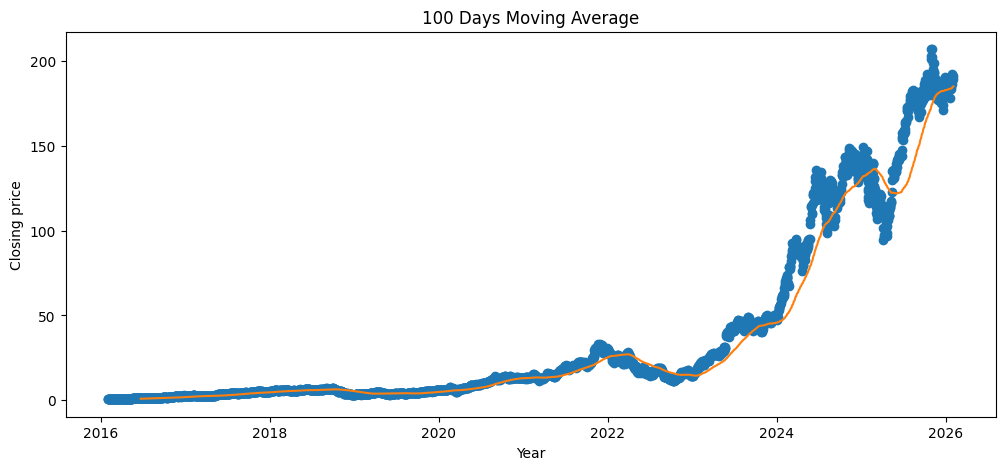

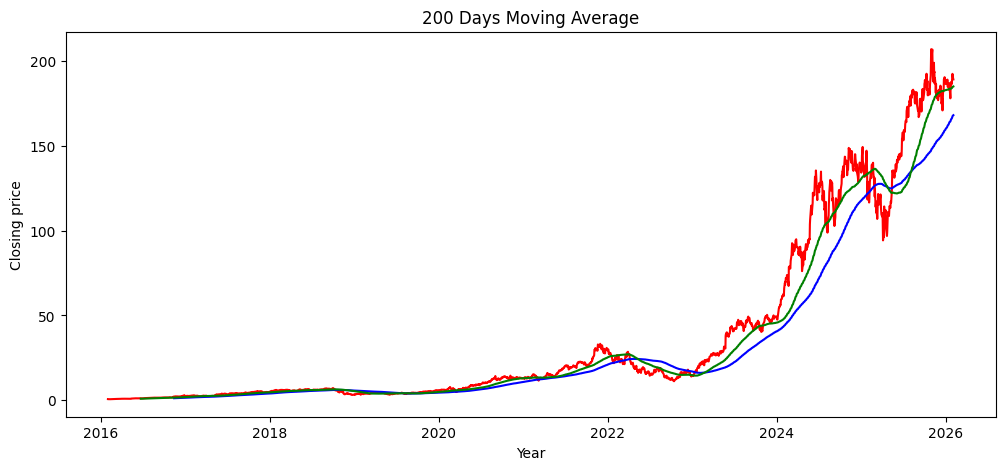

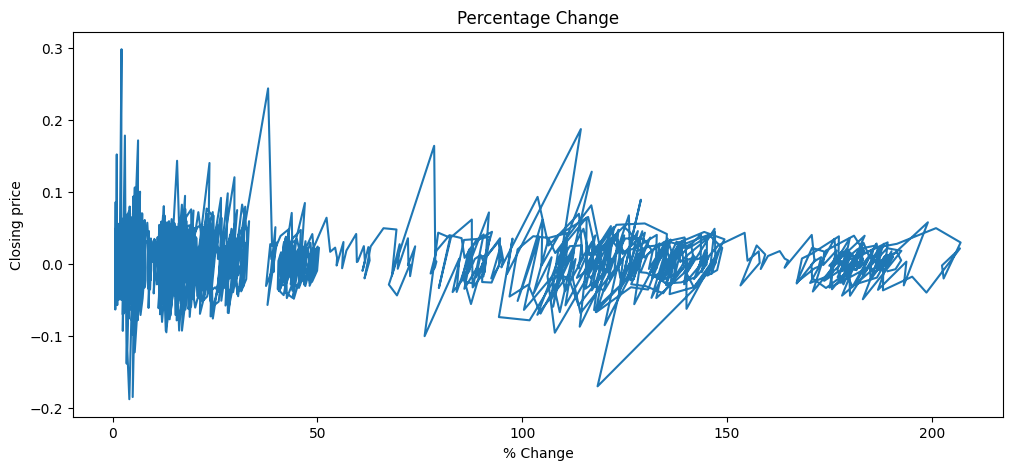

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from datetime import datetime


##1. data collection
now = datetime.now()
start=  datetime(now.year-10,now.month,now.day)
ticker = "NVDA"
df= yf.download(ticker, start, now)
df.tail(20)

##2. data exploration and visualization
plt.figure(figsize=(12,5))
plt.title(ticker)
plt.plot(df.Close);
plt.xlabel("Year")
plt.ylabel("Closing price")

##3. feature eng
df['MA_100'] = df.Close.rolling(100).mean()
plt.figure(figsize=(12,5))
plt.plot(df.Close, 'o');
plt.plot(df['MA_100']);
plt.title("100 Days Moving Average")
plt.xlabel("Year")
plt.ylabel("Closing price")


df['MA_200'] = df.Close.rolling(200).mean()
plt.figure(figsize=(12,5))
plt.plot(df.Close, 'r');
plt.plot(df['MA_200'],'b');
plt.plot(df['MA_100'],'g');
plt.title("200 Days Moving Average")
plt.xlabel("Year")
plt.ylabel("Closing price")

df['pct_change'] = df.Close.pct_change()

plt.figure(figsize=(12,5))
#plt.plot(df.Close, 'r');
plt.plot(df['Close'],df['pct_change']);
plt.title("Percentage Change")
plt.xlabel("% Change")
plt.ylabel("Closing price")


##4. data preprocessing
df.shape

# splitting data into training and testing data sets
# data_training = pd.DataFrame(df.Close[0:int(len(df) * 0.7)])
# data_testing = pd.DataFrame(df.Close[int(len(df) * 0.7): int(len(df))])
# data_training

split = int(len(df) * 0.7)

data_training = df.iloc[:split][['Close']]
data_testing  = df.iloc[split:][['Close']]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(data_training)
train_scaled

##  5 Sequence creation

x_train = []
y_train = []


for i in range(100, train_scaled.shape[0]):
    x_train.append(train_scaled.iloc[i-100:i, 0].values)
    y_train.append(train_scaled.iloc[i, 0])


x_train, y_train = np.array(x_train),np.array(y_train)

x_train
x_train.ndim


##  6 Create Model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
model = Sequential()
model.add(LSTM(
    units=128,
    activation='tanh',
    input_shape=(100, 1),
    return_sequences=True
))
model.add(LSTM(64))
model.add(Dense(25))
model.add(Dense(1))

##  7 Train Model

import tensorflow as tf
print(tf.__version__);

model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

model.fit(x_train, y_train, epochs=50);

model.summary()

#save the model
model.save("stock_prediction_model.keras")




In [60]:
#8 preparing test data
#data_testing
#past_100_days = data_training.tail(100)
past_100_days = df[['Close']].tail(100)


#final_df = pd.concat([past_100_days, df[['Close']]], axis=0)
final_df = pd.concat([past_100_days, data_testing], axis=0)

past_100_days
final_df

#data_training.head(3)
input_data = scaler.transform(final_df)
input_data
input_data.shape

x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100: i])
    y_test.append(input_data[i,0])

    # x_train.append(input_data.iloc[i-100:i, 0].values)
    # y_train.append(input_data.iloc[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test

# 9 make predictions

#x_predicted = model.predict(x_test)
y_predicted = model.predict(x_test)
y_test

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


array([3.35612892e-04, 3.52157314e-04, 3.53339223e-04, ...,
       9.24866909e-01, 9.29663065e-01, 9.22977499e-01], shape=(2514,))

In [53]:
x_test.ndim

3

In [63]:
y_predicted

array([[0.924029  ],
       [0.6117138 ],
       [0.27928102],
       ...,
       [0.8967449 ],
       [0.90847576],
       [0.9194615 ]], shape=(2514, 1), dtype=float32)